In [9]:
from stock_env.envs.single_stock_env import SingleStockEnv
import numpy as np
import pandas as pd
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.dqn import DQN
import matplotlib.pyplot as plt
from itertools import groupby

In [13]:
def maximum_drawdown(equity_s: pd.Series):
    idx = equity_s.index
    hwm = np.zeros(len(idx))
    for i in range(0, len(idx)):
        hwm[i] = max(hwm[i - 1], equity_s.iloc[i])

    perf = pd.DataFrame(index=idx)
    perf["Drawdown"] = (hwm - equity_s) / hwm
    perf["Drawdown"].iloc[0] = 0
    perf["DurationCheck"] = np.where(perf["Drawdown"] == 0, 0, 1)
    duration = max(
        sum(1 for i in g if i == 1)
        for k, g in groupby(perf["DurationCheck"])
    )

    # return np.max(perf["Drawdown"]), duration
    return perf

In [ ]:
price = np.load('price.pkl.npy')
df = pd.DataFrame()
df['A'] = price
env = SingleStockEnv(
    df=df,
    init_cash=5e4,
)
check_env(env)

model = DQN.load("log/dqn_single_stock", env=env)

In [ ]:
done = False
obs = env.reset()
while not done:
    action, _ = model.predict(obs, deterministic=True)
    print(action)
    obs, _, done, _ = env.step(action)

data = pd.concat([df, pd.DataFrame(env.history)], axis=1, join='inner')

In [2]:
data = pd.read_csv('history.csv', index_col=0)
data.head()

,A,actions,delta_shares,quantity,delta_vt,total_reward,total_profit,portfolio_value,nav,cash
0,50.000000,3,-200,-200,-84.978266,-85.339331,-84.978266,49915.021734,-10024.978266,59940.000000
1,50.124891,3,-200,-400,-71.348092,-156.941950,-156.326357,49843.673643,-20061.304623,69904.978266
2,50.153262,3,-200,-600,-101.677322,-259.136186,-258.003679,49741.996321,-30133.634256,79875.630577
3,50.222724,3,-200,-800,-187.523964,-448.418412,-445.527643,49554.472357,-40305.702972,89860.175329
4,50.382129,3,-200,-1000,-193.228905,-643.514188,-638.756549,49361.243451,-50515.357621,99876.601072


In [18]:
drawdown = maximum_drawdown(data['portfolio_value'])
drawdown = drawdown[drawdown['DurationCheck'] == 1]
drawdown.head(20)

,Drawdown,DurationCheck
1,0.001429,1
2,0.003466,1
3,0.007223,1
4,0.011094,1
5,0.009696,1
6,0.011055,1
7,0.010838,1
8,0.010690,1
9,0.011277,1
10,0.011483,1


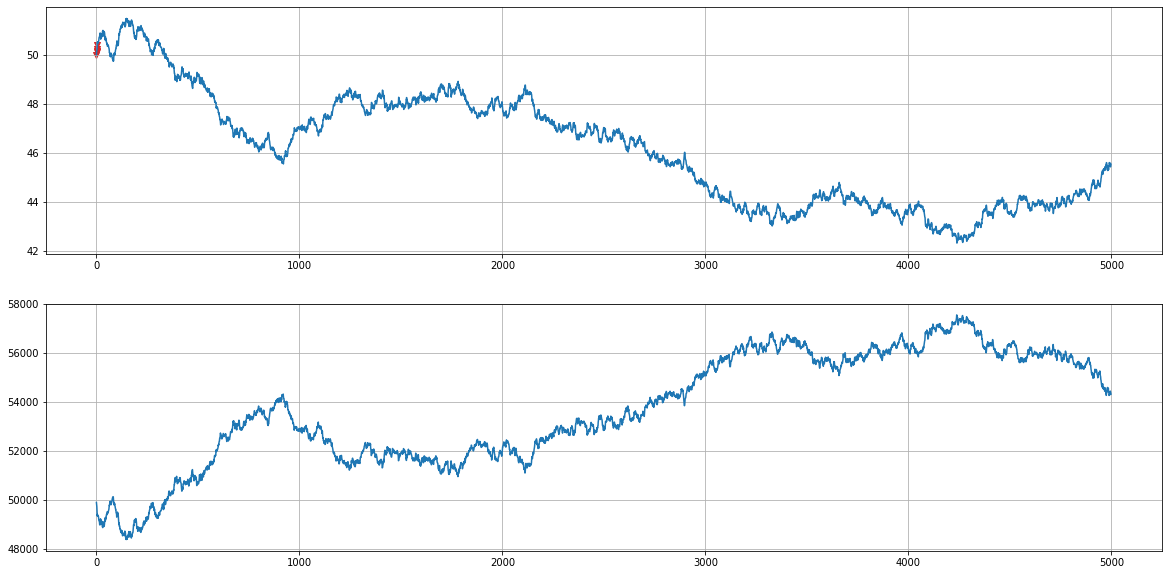

In [6]:


fig, axs = plt.subplots(2, 1, figsize=(20, 10))

buy = data[data['delta_shares'] > 0]
sell = data[data['delta_shares'] < 0]
axs[0].grid(True)
axs[0].plot(data.index, data['A'])
axs[0].scatter(buy.index, buy['A'], c='tab:green', marker='^')
axs[0].scatter(sell.index, sell['A'], c='tab:red', marker='v')


axs[1].grid(True)
axs[1].plot(data.index, data['portfolio_value'])# axs[1].scatter(buy.index, buy['A'], c='tab:green', marker='^')
